In [3]:
import os
os.chdir("..")

import pandas as pd
from utils import ROOT_DIR

import seaborn as sns
import matplotlib.pyplot as plt

# DATA

In [146]:
data = pd.read_csv(ROOT_DIR + '/data/euro-dollar.csv', sep=';')
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data.index = data['date']
data.columns = ['date', 'value']
data = data.drop('date', axis=1)

Text(0.5, 1.0, 'USD')

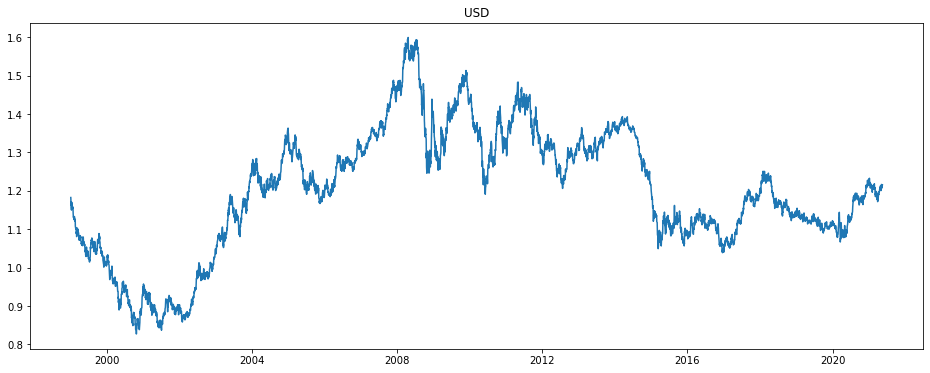

In [147]:
fig = plt.figure(figsize=(16, 6))
plt.plot(data)
plt.title('USD')

In [148]:
data.shape

(5886, 1)

# BASELINE

In [149]:
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot

In [150]:
series = data["value"].asfreq("D")
series = series.fillna(method='ffill')
series = series.sort_index()
series.head()

date
1999-01-04    1.1825
1999-01-05    1.1774
1999-01-06    1.1622
1999-01-07    1.1706
1999-01-08    1.1577
Freq: D, Name: value, dtype: float64

<AxesSubplot:xlabel='date'>

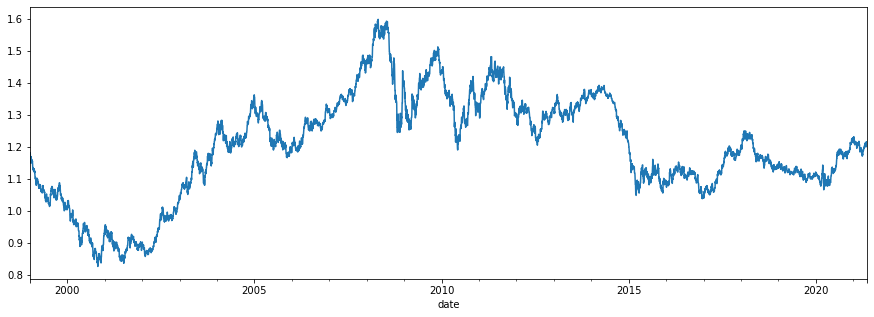

In [151]:
series.plot(figsize=(15, 5))

<AxesSubplot:xlabel='date'>

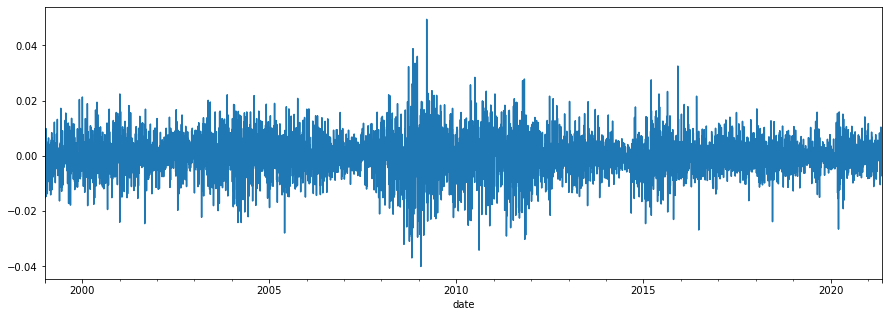

In [91]:
series_diff = series.diff(1)

series_diff.plot(figsize=(15, 5))

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

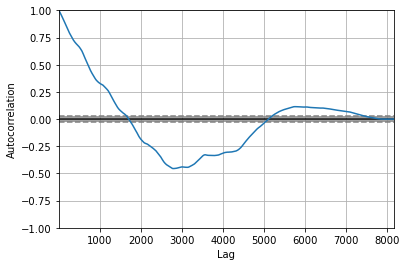

In [92]:
autocorrelation_plot(series)

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

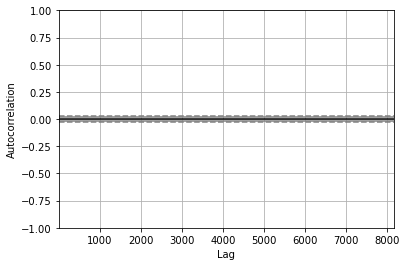

In [93]:
autocorrelation_plot(series_diff)

# TensorFlow

In [94]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.4.0-rc0


In [95]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [152]:
series.shape

(8170,)

In [153]:
series = series.values
time = np.arange(len(series), dtype="float32")

In [154]:
series

array([1.1825, 1.1774, 1.1622, ..., 1.2146, 1.2146, 1.2153])

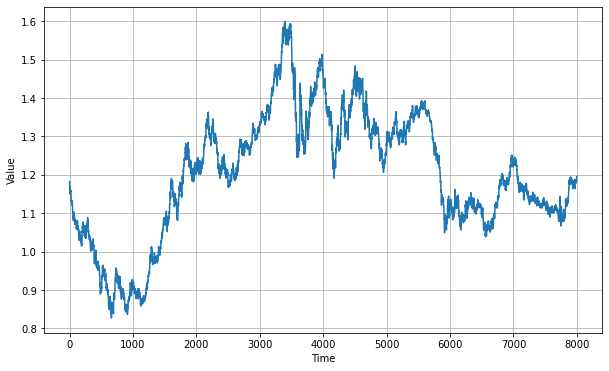

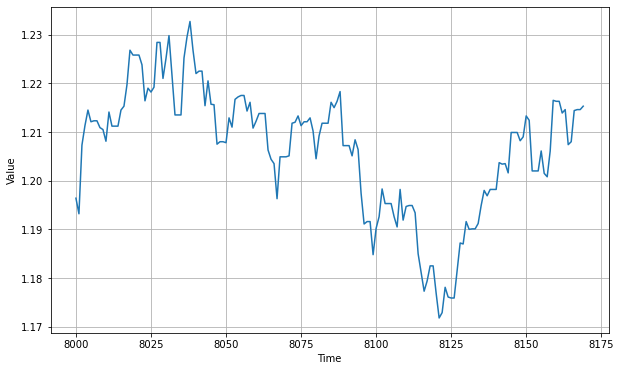

In [155]:
split_time = 8000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

# Naive Forecast

In [156]:
naive_forecast = series[split_time - 1:-1]

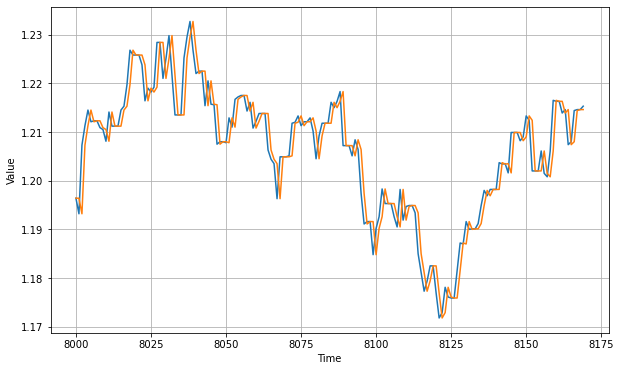

In [157]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

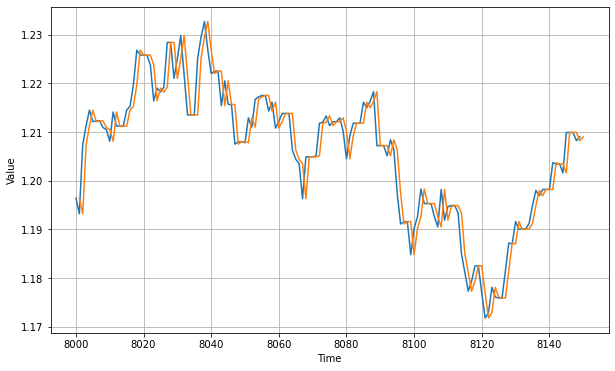

In [158]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

In [159]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

1.7167117647058684e-05
0.0028535294117646944


In [160]:
def moving_average_forecast(series, window_size):
    
    """
        Forecasts the mean of the last few values.
        If window_size=1, then this is equivalent to naive forecast
    """
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

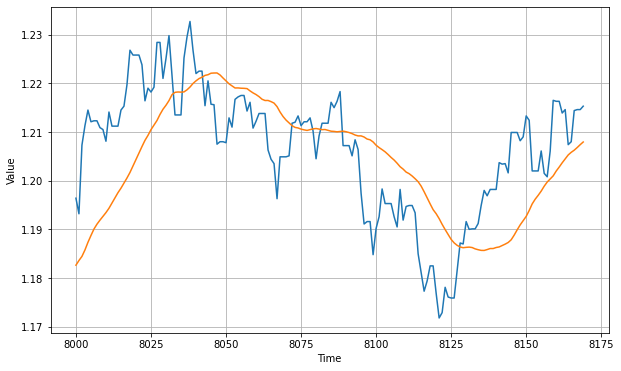

In [161]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [162]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

0.00014652383117647077
0.010125313725490213


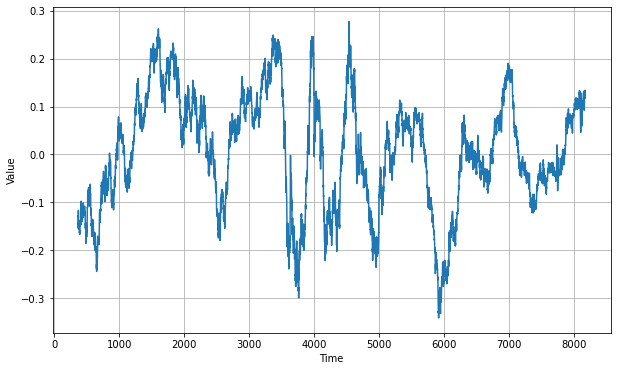

In [164]:
# remove yearly trend

diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

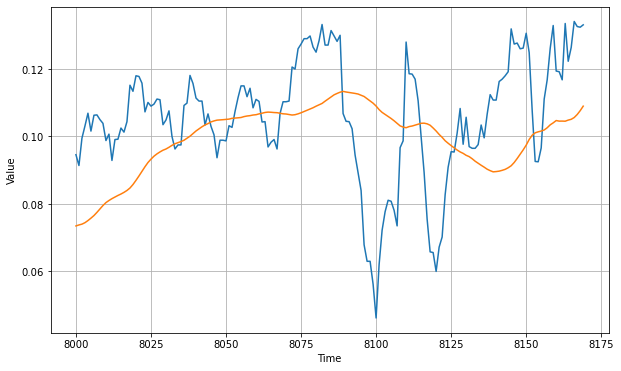

In [165]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

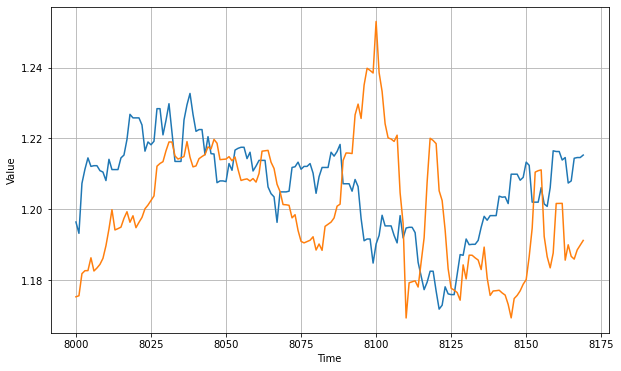

In [166]:
# bring it back
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [167]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

0.0004390447050117642
0.01726810588235294


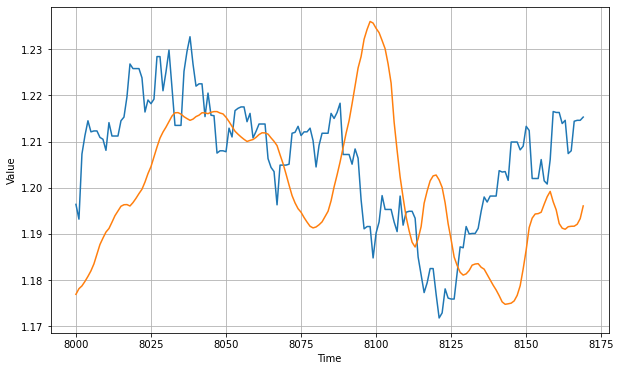

In [168]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [169]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

0.0003679094760705879
0.015953517647058803


# KERAS LINEAR

In [170]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [171]:
split_time = 8000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [172]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)



Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


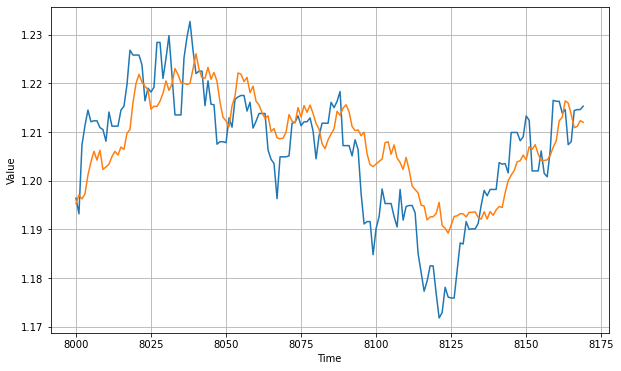

In [173]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [174]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

0.0067223287

# DeepNetwork 

In [175]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


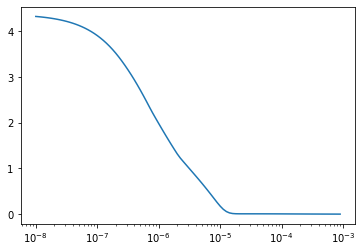

In [178]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
#plt.axis([1e-8, 1e-3, 0, 300])

In [180]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-4, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Epoch 1/500
250/250 [==============================] - 1s 2ms/step - loss: 0.2739
Epoch 2/500
250/250 [==============================] - 1s 2ms/step - loss: 5.5239e-04
Epoch 3/500
250/250 [==============================] - 1s 2ms/step - loss: 5.1090e-04
Epoch 4/500
250/250 [==============================] - 1s 2ms/step - loss: 5.0997e-04
Epoch 5/500
250/250 [==============================] - 1s 2m

250/250 [==============================] - 1s 2ms/step - loss: 3.0655e-04
Epoch 86/500
250/250 [==============================] - 1s 2ms/step - loss: 3.0275e-04
Epoch 87/500
250/250 [==============================] - 1s 2ms/step - loss: 3.0090e-04
Epoch 88/500
250/250 [==============================] - 1s 2ms/step - loss: 2.9264e-04
Epoch 89/500
250/250 [==============================] - 1s 2ms/step - loss: 2.9560e-04
Epoch 90/500
250/250 [==============================] - 1s 2ms/step - loss: 2.9792e-04
Epoch 91/500
250/250 [==============================] - 1s 2ms/step - loss: 2.9823e-04
Epoch 92/500
250/250 [==============================] - 1s 2ms/step - loss: 2.9850e-04
Epoch 93/500
250/250 [==============================] - 1s 2ms/step - loss: 2.9400e-04
Epoch 94/500
250/250 [==============================] - 1s 2ms/step - loss: 2.9288e-04
Epoch 95/500
250/250 [==============================] - 1s 2ms/step - loss: 2.9034e-04
Epoch 96/500
250/250 [==============================] - 

250/250 [==============================] - 1s 2ms/step - loss: 2.5638e-04
Epoch 179/500
250/250 [==============================] - 1s 2ms/step - loss: 2.5874e-04
Epoch 180/500
250/250 [==============================] - 1s 2ms/step - loss: 2.5627e-04
Epoch 181/500
250/250 [==============================] - 1s 2ms/step - loss: 2.5987e-04
Epoch 182/500
250/250 [==============================] - 1s 2ms/step - loss: 2.6227e-04
Epoch 183/500
250/250 [==============================] - 1s 2ms/step - loss: 2.5777e-04
Epoch 184/500
250/250 [==============================] - 1s 2ms/step - loss: 2.5928e-04
Epoch 185/500
250/250 [==============================] - 1s 2ms/step - loss: 2.5412e-04
Epoch 186/500
250/250 [==============================] - 1s 2ms/step - loss: 2.5392e-04
Epoch 187/500
250/250 [==============================] - 1s 2ms/step - loss: 2.5558e-04
Epoch 188/500
250/250 [==============================] - 1s 2ms/step - loss: 2.5504e-04
Epoch 189/500
250/250 [=======================

250/250 [==============================] - 1s 2ms/step - loss: 2.2643e-04
Epoch 272/500
250/250 [==============================] - 1s 2ms/step - loss: 2.2508e-04
Epoch 273/500
250/250 [==============================] - 1s 2ms/step - loss: 2.2651e-04
Epoch 274/500
250/250 [==============================] - 1s 2ms/step - loss: 2.2413e-04
Epoch 275/500
250/250 [==============================] - 1s 2ms/step - loss: 2.2403e-04
Epoch 276/500
250/250 [==============================] - 1s 2ms/step - loss: 2.2474e-04
Epoch 277/500
250/250 [==============================] - 1s 2ms/step - loss: 2.2693e-04
Epoch 278/500
250/250 [==============================] - 1s 2ms/step - loss: 2.2471e-04
Epoch 279/500
250/250 [==============================] - 1s 2ms/step - loss: 2.2102e-04
Epoch 280/500
250/250 [==============================] - 1s 2ms/step - loss: 2.2215e-04
Epoch 281/500
250/250 [==============================] - 1s 2ms/step - loss: 2.2016e-04
Epoch 282/500
250/250 [=======================

250/250 [==============================] - 1s 2ms/step - loss: 1.9797e-04
Epoch 364/500
250/250 [==============================] - 1s 2ms/step - loss: 1.9407e-04
Epoch 365/500
250/250 [==============================] - 1s 2ms/step - loss: 1.9714e-04
Epoch 366/500
250/250 [==============================] - 1s 2ms/step - loss: 1.9441e-04
Epoch 367/500
250/250 [==============================] - 1s 2ms/step - loss: 1.9427e-04
Epoch 368/500
250/250 [==============================] - 1s 2ms/step - loss: 1.9250e-04
Epoch 369/500
250/250 [==============================] - 1s 2ms/step - loss: 1.9393e-04
Epoch 370/500
250/250 [==============================] - 1s 2ms/step - loss: 1.9450e-04
Epoch 371/500
250/250 [==============================] - 1s 2ms/step - loss: 1.9527e-04
Epoch 372/500
250/250 [==============================] - 1s 2ms/step - loss: 1.9179e-04
Epoch 373/500
250/250 [==============================] - 1s 2ms/step - loss: 1.9286e-04
Epoch 374/500
250/250 [=======================

250/250 [==============================] - 1s 2ms/step - loss: 1.6968e-04
Epoch 457/500
250/250 [==============================] - 1s 2ms/step - loss: 1.6891e-04
Epoch 458/500
250/250 [==============================] - 1s 2ms/step - loss: 1.6975e-04
Epoch 459/500
250/250 [==============================] - 1s 2ms/step - loss: 1.6707e-04
Epoch 460/500
250/250 [==============================] - 1s 2ms/step - loss: 1.6928e-04
Epoch 461/500
250/250 [==============================] - 1s 2ms/step - loss: 1.6840e-04
Epoch 462/500
250/250 [==============================] - 1s 2ms/step - loss: 1.6733e-04
Epoch 463/500
250/250 [==============================] - 1s 2ms/step - loss: 1.6536e-04
Epoch 464/500
250/250 [==============================] - 1s 2ms/step - loss: 1.6654e-04
Epoch 465/500
250/250 [==============================] - 1s 2ms/step - loss: 1.6741e-04
Epoch 466/500
250/250 [==============================] - 1s 2ms/step - loss: 1.6663e-04
Epoch 467/500
250/250 [=======================

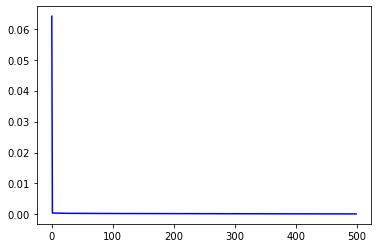

In [181]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[0.00040555259329266846, 0.00039885236765258014, 0.00039470268529839814, 0.00038568818126805127, 0.0003839425335172564, 0.000377257150830701, 0.0003738457744475454, 0.0003703226684592664, 0.0003670025907922536, 0.00036415967042557895, 0.0003652968443930149, 0.00036189856473356485, 0.0003555204311851412, 0.00035290472442284226, 0.00035045453114435077, 0.0003501399187371135, 0.00034772828803397715, 0.00034561502980068326, 0.00034467721707187593, 0.00034338259138166904, 0.0003414171515032649, 0.00033895124215632677, 0.00033579752198420465, 0.00033716694451868534, 0.0003346777521073818, 0.0003345658187754452, 0.0003335179353598505, 0.00033081823494285345, 0.0003314336354378611, 0.0003287866129539907, 0.00032580638071522117, 0.00032711707171984017, 0.00032364713842980564, 0.00032610795460641384, 0.000324971042573452, 0.00032284550252370536, 0.000321511528454721, 0.0003218545170966536, 0.0003221941296942532, 0.00031834610854275525, 0.0003183155495207757, 0.00031827736529521644, 0.00031512285

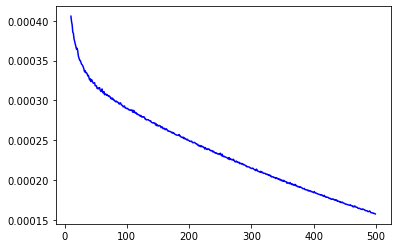

In [182]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(10, len(loss))
plot_loss = loss[10:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

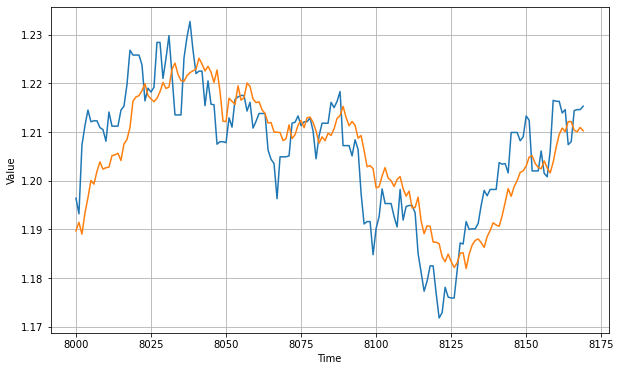

In [183]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid[-7:], x_valid[-7:])
plot_series(time_valid[-7:], results[-7:])

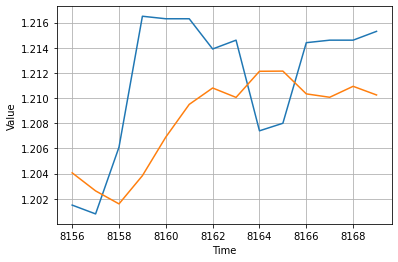

In [187]:
plot_series(time_valid[-14:], x_valid[-14:])
plot_series(time_valid[-14:], results[-14:])

In [191]:
len(series) - window_size

8140

In [192]:
model.predict(series[8140:8140+window_size][np.newaxis])

array([[1.209364]], dtype=float32)

In [193]:
model.predict(series[-window_size:][np.newaxis])

array([[1.209364]], dtype=float32)

In [194]:
series[-1]

1.2153

In [184]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

0.006303004

In [185]:
forecast

[array([[1.189688]], dtype=float32),
 array([[1.1914479]], dtype=float32),
 array([[1.1890274]], dtype=float32),
 array([[1.19335]], dtype=float32),
 array([[1.1964929]], dtype=float32),
 array([[1.2000529]], dtype=float32),
 array([[1.1992835]], dtype=float32),
 array([[1.201893]], dtype=float32),
 array([[1.2038574]], dtype=float32),
 array([[1.2023553]], dtype=float32),
 array([[1.20267]], dtype=float32),
 array([[1.2027721]], dtype=float32),
 array([[1.205145]], dtype=float32),
 array([[1.2052978]], dtype=float32),
 array([[1.2056417]], dtype=float32),
 array([[1.2041484]], dtype=float32),
 array([[1.207535]], dtype=float32),
 array([[1.208454]], dtype=float32),
 array([[1.2108917]], dtype=float32),
 array([[1.2163361]], dtype=float32),
 array([[1.2171897]], dtype=float32),
 array([[1.2174653]], dtype=float32),
 array([[1.2184858]], dtype=float32),
 array([[1.2199169]], dtype=float32),
 array([[1.2174798]], dtype=float32),
 array([[1.2168057]], dtype=float32),
 array([[1.2162186]],